# Mask R-CNN - Train on Landing Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [11]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import skimage
import skimage.io
import scipy
import json
import matplotlib
import matplotlib.pyplot as plt

from mrcnn.config import Config
import mrcnn.utils as utils
import mrcnn.model as modellib
import mrcnn.visualize as visualize
from mrcnn.model import log

import landing
%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to COCO and landing pretrained weights
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
LANDING_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_landing.h5")

CUSTOM_DIR =  os.path.join(ROOT_DIR, "dataset")

c:\users\instructor\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

In [12]:
class LandingConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "landing"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STPES = 5
    
    # Backbone structure
    BACKBONE = 'resnet101'
    
config = LandingConfig()
# config.print()

## Notebook Preferences

In [13]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [14]:
class LandingDataset(utils.Dataset):

    def load_landing(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes
        self.add_class("landing", 1, "safe")
        self.add_class("landing", 2, "unsafe")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

       
        # We mostly care about the x and y coordinates of each region
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        idlist =[]
        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions'].values()]
            class_ids =  [r['region_attributes'] for r in a['regions'].values()]
            
            idlist =[]
            for i in range(len(class_ids)):
                if class_ids[i]['safety'] == 'unsafe':
                    idlist.append(2)
                elif class_ids[i]['safety'] == 'safe':
                    idlist.append(1)
            
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "landing",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                class_ids=idlist)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "landing":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask, np.array(info['class_ids'], dtype=np.int32) #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "landing":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [15]:
# Training dataset
dataset_train = LandingDataset()
dataset_train.load_landing(CUSTOM_DIR, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = LandingDataset()
dataset_val.load_landing(CUSTOM_DIR, "val")
dataset_val.prepare()

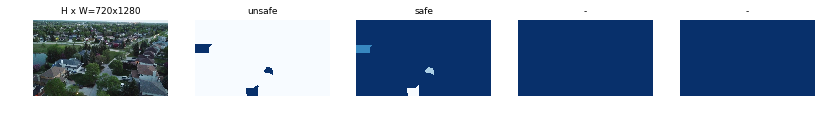

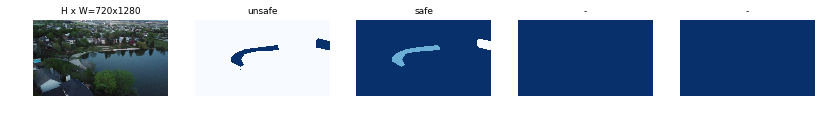

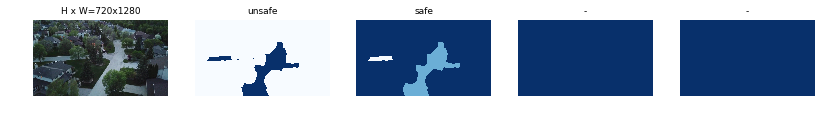

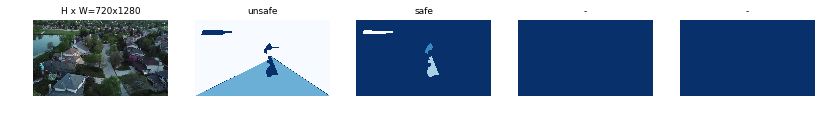

In [16]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4) # dataset.image_ids
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Ceate Model

In [17]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [18]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "landing":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(LANDING_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [9]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\Instructor\Desktop\landing\logs\landing20180607T0934\mask_rcnn_landing_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistrib

c:\users\instructor\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
100/100 [==============================] - 883s 9s/step - loss: 0.7844 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.3876 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.1204 - mrcnn_mask_loss: 0.1902 - val_loss: 0.8045 - val_rpn_class_loss: 0.0143 - val_rpn_bbox_loss: 0.3681 - val_mrcnn_class_loss: 0.1195 - val_mrcnn_bbox_loss: 0.1213 - val_mrcnn_mask_loss: 0.1813


In [10]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: C:\Users\Instructor\Desktop\landing\logs\landing20180607T0934\mask_rcnn_landing_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (C

c:\users\instructor\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 2/2
 99/100 [============================>.] - ETA: 11s - loss: 0.6782 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.3238 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.1011 - mrcnn_mask_loss: 0.1784

ERROR:root:Error processing image {'source': 'landing', 'id': 'flying 63.jpg', 'path': 'C:\\Users\\Instructor\\Desktop\\landing\\dataset\\val\\flying 63.jpg', 'class_ids': [2, 2, 1], 'height': 720, 'width': 1280, 'polygons': [{'all_points_y': [663, 2, 1, 719, 718, 699, 643, 601, 593, 605, 658, 663], 'all_points_x': [1278, 1279, 0, 2, 788, 805, 893, 1014, 1116, 1156, 1188, 1278], 'name': 'polygon'}, {'all_points_y': [718, 718, 708, 712, 707, 700, 700, 718], 'all_points_x': [1034, 1277, 1277, 1237, 1189, 1147, 1088, 1034], 'name': 'polygon'}, {'all_points_y': [719, 703, 681, 642, 625, 602, 592, 604, 658, 663, 664, 710, 711, 708, 701, 700, 719, 719], 'all_points_x': [788, 803, 839, 896, 938, 1008, 1115, 1155, 1187, 1230, 1278, 1278, 1236, 1190, 1149, 1092, 1025, 788], 'name': 'polygon'}]}
Traceback (most recent call last):
  File "C:\Users\Instructor\Desktop\landing\mrcnn\model.py", line 1695, in data_generator
  File "C:\Users\Instructor\Desktop\landing\mrcnn\model.py", line 1209, in loa

ERROR:root:Error processing image {'source': 'landing', 'id': 'flying 08.jpg', 'path': 'C:\\Users\\Instructor\\Desktop\\landing\\dataset\\val\\flying 08.jpg', 'class_ids': [1, 2, 1], 'height': 720, 'width': 1280, 'polygons': [{'all_points_y': [201, 216, 232, 257, 272, 283, 296, 315, 306, 240, 232, 214, 199, 201], 'all_points_x': [1046, 1035, 1047, 1046, 1027, 1029, 1051, 1065, 1092, 1096, 1085, 1095, 1094, 1046], 'name': 'polygon'}, {'all_points_y': [718, 704, 697, 701, 717, 694, 658, 624, 578, 526, 492, 482, 449, 453, 434, 424, 395, 384, 392, 395, 423, 445, 465, 292, 285, 272, 254, 232, 216, 204, 198, 212, 233, 238, 305, 313, 298, 293, 465, 543, 550, 566, 570, 594, 615, 607, 621, 626, 647, 669, 656, 658, 675, 690, 690, 717, 717, 1, 0, 717, 718], 'all_points_x': [425, 419, 410, 392, 362, 283, 260, 255, 318, 370, 421, 469, 535, 572, 638, 763, 803, 807, 836, 844, 840, 826, 840, 1043, 1026, 1023, 1046, 1044, 1033, 1043, 1092, 1096, 1082, 1096, 1094, 1065, 1052, 1040, 840, 826, 842, 848, 8

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Instructor\\Desktop\\landing\\dataset\\val\\flying 08.jpg'

In [10]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_landing.h5")
model.keras_model.save_weights(model_path)

NameError: name 'os' is not defined

## Detection

In [19]:
class InferenceConfig(LandingConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  C:\Users\Instructor\Desktop\landing\logs\landing20180607T0934\mask_rcnn_landing_0001.h5


original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 1280.00000  float64
gt_bbox                  shape: (3, 4)                min:    1.00000  max:  511.00000  int32
gt_mask                  shape: (512, 512, 3)         min:    0.00000  max:    1.00000  uint8


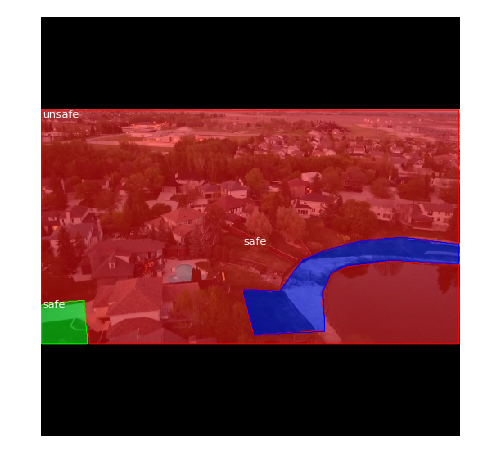

In [20]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, cls_ids, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, cls_ids, 
                            dataset_train.class_names, figsize=(8, 8),show_bbox=False)

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


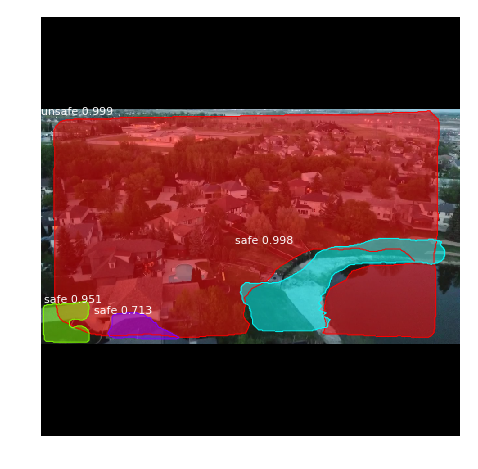

In [21]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax(),show_bbox=False)

## Evaluation

In [22]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = dataset_val.image_ids #np.random.choice(dataset_val.image_ids, 2)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.9320987683755378
